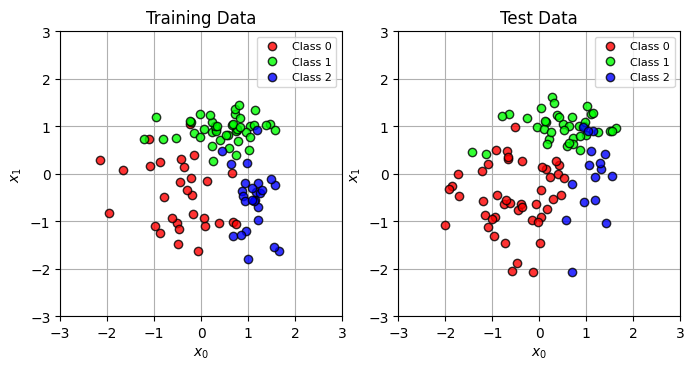

In [ ]:
#week11_1.txt

import numpy as np

# 데이터 생성
np.random.seed(seed = 1) # 난수를 고정
N = 200 # 데이터의 수
K = 3 #  분포의 수, 클래스의 수
T = np.zeros((N, 3), dtype = np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 각 분포에 대한 비율

for n in range(N):
    wk = np.random.rand()

    for k in range(K):
        if wk < Pi[k]:
            T[n, k] = 1
            break

    for k in range(2):
        X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + Mu[T[n, :] == 1, k]


# 2분류 데이터를 테스트 훈련 데이터로 분할
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:,:]
T_train = T[:X_n_training, :]
T_test = T[X_n_training:,:]

# 데이터를 'class_data.npz' 에 저장
np.savez('class_data.npz', X_train = X_train, T_train = T_train, X_test = X_test, T_test = T_test, X_range0 = X_range0, X_range1 = X_range1)


import matplotlib.pyplot as plt
%matplotlib inline

# 데이터를 그리기
def Show_data(x, t):
    wk, n = t.shape
    #c = [[0, 0, 0], [0.5, 0.5, 0.5], [1, 1, 1]] # 컬러 값 설정
    c = [[1, 0, 0], [0, 1, 0], [0, 0, 1]] # 컬러 값 설정 [r, g, b]

    for i in range(n):
         plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1], linestyle = 'none', markeredgecolor = 'black', marker = 'o', color = c[i], alpha = 0.8)
        # K 값을 0, 1, 2로 바꾸어 주면서 부류벡터 t 에 접근 부류번호가 일치하는 인덱스드을 모두 찾아준다
        # 따라서, 부류가 0번인 샘플들의 (x1, x2) 위치에 포인트를 먼저 다 찍고, 그 다음 부류로 순차적으로 찍게 된다
    plt.grid(True)


# 메인
plt.figure(1, figsize = (8, 3.7))
plt.subplot(1, 2, 1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Training Data')
plt.legend(('Class 0','Class 1', 'Class 2'), loc='upper right', fontsize=8)

plt.subplot(1, 2, 2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Test Data')
plt.legend(('Class 0','Class 1', 'Class 2'), loc='upper right', fontsize=8)

plt.show()

In [ ]:
# 훈련 데이터셋 5개 출력
print("X_train", X_train.shape)
print(X_train[:5,:])
print("T_train", T_train.shape)
print(T_train[:5,:])

X_train (100, 2)
[[-0.14173827  0.86533666]
 [-0.86972023 -1.25107804]
 [-2.15442802  0.29474174]
 [ 0.75523128  0.92518889]
 [-1.10193462  0.74082534]]
T_train (100, 3)
[[0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]]


In [ ]:
# 테스트 데이터셋 5개 출력
print("X_test", X_test.shape)
print(X_test[:5, :])
print("T_test", T_test.shape)
print(T_test[:5, :])

X_test (100, 2)
[[ 0.42570153  0.18821111]
 [ 1.10704453  1.26547264]
 [ 0.01517889 -1.44595338]
 [-0.67792591  0.47989076]
 [ 0.84929022  1.01146649]]
T_test (100, 3)
[[1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]]


In [ ]:
# 시그모이드 함수
def Sigmoid(x) :
    y = 1 / (1 + np.exp(-x))
    return y

In [ ]:
# 2층 피드 포워드 신경망 구현
def FNN(wv, M, K, x) :
    # wv : 전체 가중치를 길이 {(D+1) * M} + {(M + 1) * K} 벡터로 전달
    # M : 은닉층의 뉴런 수
    # K : 출력층의 뉴런 수
    N, D = x.shape # N = 샘플 수, D = 특징벡터의 길이
    w = wv[: M * (D+1)] #은닉층의 가중치를 가져온다
    w = w.reshape((M, D + 1)) # M x (D+1) 행렬로 변환
    v = wv[M * (D+1) :] #출력층의 가중치를 가져온다
    v = v.reshape((K, M + 1)) # K x (M+1) 행렬로 변환
    b = np.zeros((N, M + 1)) # 은닉층의 가중합을 저장하기 위한 공간
    z = np.zeros((N, M + 1)) # 은닉층의 출력을 저장하기 위한 공간
    a = np.zeros((N, K)) # 출력층의 가중합을 저장하기 위한 공간
    y = np.zeros((N, K)) # 출력층의 출력을 저장하기 위한 공간

    for n in range(N) : # 개별 샘플 별 계산
        #은닉층의 계산
        for m in range(M) :
            b[n, m] = np.dot(w[m, :], np.r_[x[n, :], 1]) #가중합 연산
            #np.r_[x[n, :], 1] 바이어스 추가하는 부분
            z[n, m] = Sigmoid(b[n, m]) #활성화 함수

        #출력층의 계산
        z[n, M] = 1 #bias 값 1 저장
        wkz = 0 # 소프트맥스 함수의 분모 값 저장을 위한 변수

        for k in range(K) :
            a[n, k] = np.dot(v[k, :], z[n, :])
            wkz = wkz + np.exp(a[n, k]) #소프트맥수 함수의 분모 값 계산

        for k in range(K) :
            y[n, k] = np.exp(a[n, k]) / wkz #최종 출력 계산

    return y, a, z, b


In [ ]:
#모든 가중치가 1이고, 3개의 데이터를 입력으로 하였을 때 FNN의 출력
WV = np.ones(15)
M = 2
K = 3
FNN(WV, M, K, X_train[:2, :])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

In [ ]:
def CE_FNN(wv, M, K, x, t) :
    N, D = x.shape
    y, a, z, b = FNN(wv, M, K, x)
    ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
    # N x K 행렬인 y와 t 행렬을 reshapte(-1)을 활용
    #1차원 행벡터로 변환 시킨 후 내적을 구하면
    #교차 엔트로피 오차를 쉽게 구할 수 있다.
    return ce

In [ ]:
WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M, K, X_train[:2, :], T_train[:2, :])

1.0986122886681098

In [ ]:
def dCE_FNN_num(wv, M, K, x, t) :
    epsilon = 0.001#0.001
    dwv = np.zeros_like(wv)

    for iwv in range(len(wv)) :
        wv_modified = wv.copy()
        wv_modified[iwv] = wv[iwv] - epsilon
        mse1 = CE_FNN(wv_modified, M, K, x, t)
        wv_modified[iwv] = wv[iwv] + epsilon
        mse2 = CE_FNN(wv_modified, M, K, x, t)
        dwv[iwv] = (mse2 - mse1) / (2 * epsilon)

    return dwv

In [ ]:
def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha) :
    wvt = wv_init
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))
    epsilon = 0.001

    for i in range(n) :
        wvt = wvt - alpha * dCE_FNN_num(wvt, M, K, x_train, t_train)
        err_train[i] = CE_FNN(wvt, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wvt, M, K, x_test, t_test)
        wv_hist[i, :] = wvt

    return wvt, wv_hist, err_train, err_test

In [ ]:
M = 2
K = 3

np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))

N_step = 1000
alpha = 0.5

In [ ]:
import time

startTime = time.time()
WV, WV_hist, Err_train, Err_test = Fit_FNN_num(WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)

caculation_time = time. time() - startTime
print("Calculation time : {:.3f} sec.".format(caculation_time))

Calculation time : 38.810 sec.


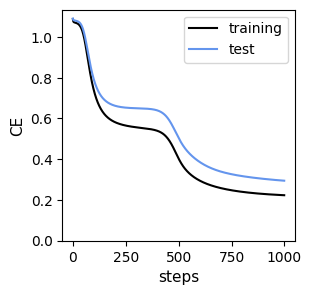

In [ ]:
# week10_2.txt
# 학습 오차의 표시
plt.figure(1, figsize = (3, 3))
plt.plot(Err_train, 'black', label = 'training')
plt.plot(Err_test, 'cornflowerblue', label = 'test')
plt.xlabel('steps', fontsize = 11)
plt.ylabel('CE', fontsize = 11)
plt.ylim(0, )
plt.legend()
plt.show()

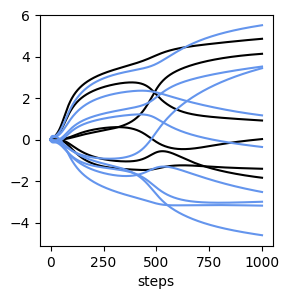

Black: w, Cornflowerblue: v


In [ ]:
# week10_3.txt
# 가중치의 시간 변화의 표시
plt.figure(1, figsize = (3, 3))
plt.plot(WV_hist[:, : M * 3], 'black')
plt.plot(WV_hist[:, M * 3 :], 'cornflowerblue')
plt.xlabel("steps")
plt.show()
print("Black: w, Cornflowerblue: v")

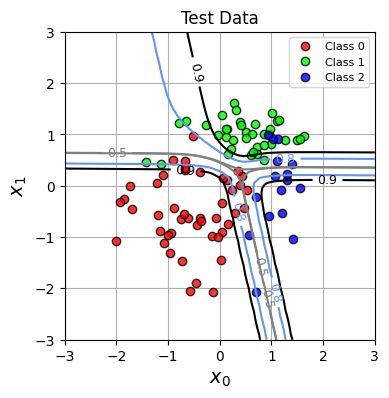

In [ ]:
# week10_4.txt
# 경계선 표시 함수
# 각각의 카테고리에서 0.5, 0.8, 0.9 이상의 출력을 얻을 수 있는 영역을 등고선으로 표시
def show_FNN(wv, M, K):
    xn = 60 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx1, (xn * xn, 1)), np.reshape(xx0, (xn * xn, 1))] # np.c_ column 추가
    y, a, z, b = FNN(wv, M, K, x)
    plt.figure(1, figsize = (5, 5))

    for ic in range(K):
        f = y[: , ic]
        f = f.reshape(xn, xn)
        f = f.T
        cont = plt.contour(xx0, xx1, f, levels = [0.5, 0.8, 0.9], colors = ['gray', 'cornflowerblue', 'black'])
        cont.clabel(fmt = '%1.1f', fontsize = 9)

    plt.xlim(X_range0)
    plt.ylim(X_range1)


# 경계선 표시
plt.figure(1, figsize = (4, 4))
Show_data(X_test,T_test)
show_FNN(WV, M, K)
plt.xlabel('$x_0$', fontsize = 14)
plt.ylabel('$x_1$', fontsize = 14)
plt.title('Test Data')
plt.legend(('Class 0','Class 1', 'Class 2'), loc='upper right', fontsize=8)
plt.show()

In [ ]:
def dCE_FNN(wv, M, K, x, t) :
    N, D = x.shape

    w = wv[ : M * (D + 1)]
    w = w.reshape(M, (D + 1))
    v = wv[ M * (D + 1): ]
    v = v.reshape((K, M + 1))

    y, a, z, b = FNN(wv, M, K, x)

    dwv = np.zeros_like(wv)
    dw = np.zeros((M, D + 1))
    dv = np.zeros((K, M + 1))
    delta1 = np.zeros(M)
    delta2 = np.zeros(K)

    for n in range(N) :
        for k in range(K) :
            delta2[k] = (y[n, k] - t[n, k])
        for j in range(M) :
            delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:, j], delta2)
        for k in range(K) :
            dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N
        for j in range(M) :
            dw[j, :] = dw[j, :] + delta1[j] * np.r_[x[n, :], 1] / N

    dwv = np.c_[dw.reshape((1, M * (D + 1))), dv.reshape((1, K * (M + 1)))]
    dwv = dwv.reshape(-1)

    return dwv

In [ ]:
M = 2
K = 3

N = 2
nWV = M * 3 + K * (M+1)
np.random.seed(1)

WV = np.random.normal(0, 1, nWV)

dWV_ana = dCE_FNN(WV, M, K, X_train[ : N, : ], T_train[ : N, :])

print("analytical dWV")
print(dWV_ana)

dWV_num = dCE_FNN_num(WV, M, K, X_train[ : N, : ], T_train[ : N, :])
print("numerical dWV")
print(dWV_num)

analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


Text(0.5, 0, '$i$')

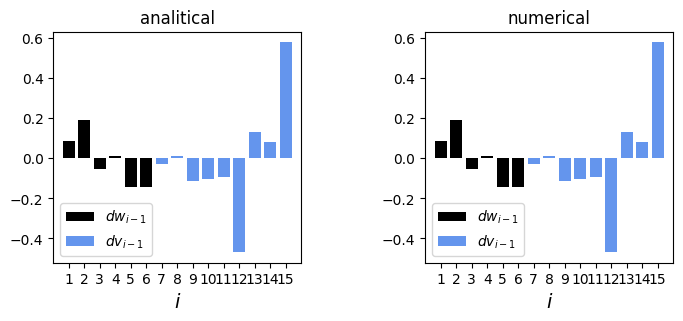

In [ ]:
# week12_1
# Show dWV
def Show_dWV(wv, M):
    N = wv.shape[0]
    plt.bar(range(1, M * 3 + 1), wv[ : M * 3], align = "center", color = 'black', label = '$dw_{i-1}$')
    plt.bar(range(M * 3 + 1, N + 1), wv[M * 3 : ], align = "center", color = 'cornflowerblue', label = '$dv_{i-1}$')
    plt.xticks(range(1, N + 1))
    plt.xlim(0, N +1)
    plt.legend(loc = "lower left", fontsize = 14)
    plt.xlabel('$i$', fontsize=14)


plt.figure(1, figsize = (8, 3))
plt.subplots_adjust(wspace = 0.5)
plt.subplot(1, 2, 1)
Show_dWV(dWV_ana, M)
plt.title('analitical')
plt.legend(loc = "lower left")
plt.xlabel('$i$', fontsize=14)

plt.subplot(1, 2, 2)
Show_dWV(dWV_num, M)
plt.title('numerical')
plt.legend(loc = "lower left")
plt.xlabel('$i$', fontsize=14)

In [ ]:
def Fit_FNN(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha) :
    wv = wv_init.copy()
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))

    for i in range(n) :
        wv = wv - alpha * dCE_FNN(wv, M, K, x_train, t_train)
        err_train[i] = CE_FNN(wv, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wv, M, K, x_test, t_test)
        wv_hist[i, :] = wv

    return wv, wv_hist, err_train, err_test


In [ ]:
import time

start_time = time.time()
M = 2
K = 3

np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000
alpha = 0.5

WV, WV_hist, Err_train, Err_test = Fit_FNN(WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)

calculation_time = time.time() - start_time
print("Calculation time: {:3f} sec". format(calculation_time))

Calculation time: 5.444924 sec


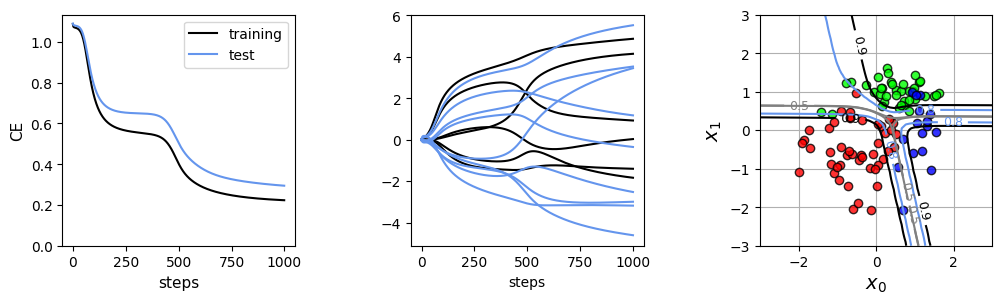

In [ ]:
# week12_2
plt.figure(1, figsize = (12, 3))
plt.subplots_adjust(wspace = 0.5)

# 학습 오차의 표시
plt.subplot(1, 3, 1)
plt.plot(Err_train, 'black', label = 'training')
plt.plot(Err_test, 'cornflowerblue', label = 'test')
plt.xlabel('steps', fontsize = 11)
plt.ylabel('CE', fontsize = 11)
plt.ylim(0, )
plt.legend()

# 가중치의 시간 변화 표시
plt.subplot(1, 3, 2)
plt.plot(WV_hist[:, : M * 3], 'black')
plt.plot(WV_hist[:, M * 3 :], 'cornflowerblue')
plt.xlabel("steps")

# 경계선 표시
plt.subplot(1, 3, 3)
Show_data(X_test,T_test)
show_FNN(WV, M, K)
plt.xlabel('$x_0$', fontsize = 14)
plt.ylabel('$x_1$', fontsize = 14)
plt.show()


In [ ]:
import tensorflow.keras.optimizers

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Activation

In [ ]:
np.random.seed(1)

model = Sequential()

model.add(Dense(2, input_dim=2, activation='sigmoid', kernel_initializer='uniform'))

model.add(Dense(3, activation='softmax', kernel_initializer='uniform'))

from tensorflow.keras.optimizers.legacy import SGD

sgd = SGD(learning_rate=1, momentum=0.0, decay=0.0, nesterov=False)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 dense_1 (Dense)             (None, 3)                 9         
                                                                 
Total params: 15 (60.00 Byte)
Trainable params: 15 (60.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
start_time = time.time()

history = model.fit(X_train, T_train, epochs=1000, batch_size=100, verbose=1, validation_data=(X_test, T_test))

calculation_time = time.time() - start_time

Epoch 1/1000
1/1 [==============================] - 0s 169ms/step - loss: 1.0954 - accuracy: 0.4400 - val_loss: 1.0828 - val_accuracy: 0.3800
Epoch 2/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.0775 - accuracy: 0.4400 - val_loss: 1.0814 - val_accuracy: 0.3800
Epoch 3/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.0730 - accuracy: 0.4400 - val_loss: 1.0810 - val_accuracy: 0.3800
Epoch 4/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.0717 - accuracy: 0.4400 - val_loss: 1.0805 - val_accuracy: 0.3800
Epoch 5/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.0710 - accuracy: 0.4400 - val_loss: 1.0799 - val_accuracy: 0.3800
Epoch 6/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.0703 - accuracy: 0.4400 - val_loss: 1.0793 - val_accuracy: 0.3800
Epoch 7/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.0697 - accuracy: 0.4400 - val_loss: 1.0786 - val_accuracy: 0.3800
Epoch 8/1000
1

In [ ]:
print("calculation_time: {:3f} sec".format(caculation_time))

calculation_time: 38.810136 sec


In [ ]:
history = history.history
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
score = model.evaluate(X_test, T_test, verbose=0)

print("cross entropy {:.2f}, accuracy {:.2f}".format(score[0], score[1]))

cross entropy 0.26, accuracy 0.90


113/113 [==============================] - 0s 187us/step


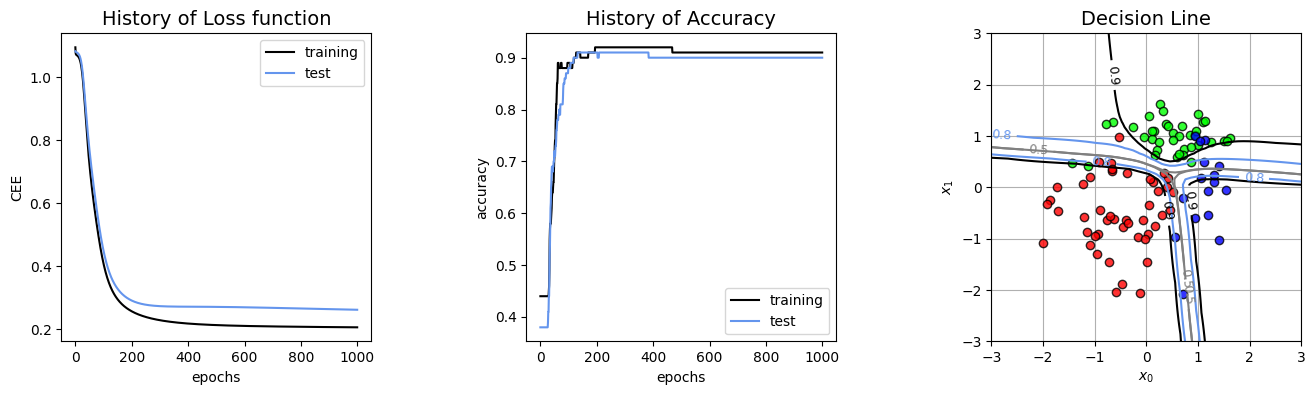

In [ ]:
# week12_3
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터를 그리기
def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [0.5, 0.5, 0.5], [1, 1, 1]] # 컬러 값 설정
    c = [[1, 0, 0], [0, 1, 0], [0, 0, 1]] # 컬러 값 설정 [r, g, b]

    for i in range(n):
         plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1], linestyle = 'none', markeredgecolor = 'black', marker = 'o', color = c[i], alpha = 0.8)
        # K 값을 0, 1, 2로 바꾸어 주면서 부류벡터 t 에 접근 부류번호가 일치하는 인덱스드을 모두 찾아준다
        # 따라서, 부류가 0번인 샘플들의 (x1, x2) 위치에 포인트를 먼저 다 찍고, 그 다음 부류로 순차적으로 찍게 된다
    plt.grid(True)

# 리스트 7-2-(4)
plt.figure(1, figsize = (16, 4))
plt.subplots_adjust(wspace = 0.5)

# 학습 곡선 표시
plt.subplot(1, 3, 1)
plt.plot(history['loss'], 'black', label = 'training')
# (A) 학습 과정의 훈련 데이터의 교차 엔트로피 오차의 시계열 정보
plt.plot(history['val_loss'], 'cornflowerblue', label ='test')
# (B) 학습 과정의 평가용 데이터의의 교차 엔트로피 오차
plt.legend()
plt.xlabel('epochs')
plt.ylabel('CEE')
plt.title('History of Loss function', fontsize = 14)


# 정확도 표시
plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], 'black', label = 'training')
# (C) 훈련 데이터의 정답률 변화
plt.plot(history['val_accuracy'], 'cornflowerblue', label = 'test')
# (D) 평가용 데이터의 정답률 변화
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('History of Accuracy', fontsize = 14)


# 경계선 표시
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
xn = 60 # 등고선 표시 해상도
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')] # np.c_ column 추가
#y, a, z, b = FNN(wv, M, K, x)
y = model.predict(x) # (E) 학습이 완료된 모델에 입력 x에 대한  출력
K = 3

for ic in range(K):
    f = y[: , ic]
    f = f.reshape(xn, xn)
    f = f.T
    cont = plt.contour(xx0, xx1, f, levels = [0.5, 0.8, 0.9], colors = ['gray', 'cornflowerblue', 'black'])
    cont.clabel(fmt = '%1.1f', fontsize = 9)

plt.xlim(X_range0)
plt.ylim(X_range1)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Decision Line', fontsize = 14)

plt.show()